In [1]:
from pygmo import hypervolume
import csv
import statistics
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#### Modified from Pau's code
def compute_pareto_front(population):
    #print(np.shape(np.array(population)))
    #print(population)
    pop_size = len(population)
    obj_num = 2

    domination_counter = [0] * pop_size

    for i in range(pop_size):
        for j in range(i+1, pop_size):
            # check each objective for dominance
            dominate = [0] * obj_num
            for k in range(obj_num):
                if population[i][k] > population[j][k]:
                    dominate[k] = 1
                elif population[i][k] < population[j][k]:
                    dominate[k] = -1
            if -1 not in dominate and 1 in dominate:
                domination_counter[i] += 1
            elif -1 in dominate and 1 not in dominate:
                domination_counter[j] += 1

    pareto_solutions = []
    for i in range(len(domination_counter)):
        if domination_counter[i] == 0:
            pareto_solutions.append(population[i])
    return pareto_solutions

def compute_hv(population):
    array_archs = np.zeros((len(population), 2))
    for i in range(len(population)):
        array_archs[i] = population[i]
    hv_object = hypervolume(array_archs)
    hv = hv_object.compute([1.1,1.1])/1.1**2
    return hv

In [3]:
#### Useful functions and parameter defintions
nfe_interval = 50

def compute_true_objectives(pen_obj1, pen_obj2, feas_score, stab_score, fib_stiff):
    pen_fac = 1
    if fib_stiff:
        pen_fac = 1.5
    pen = (np.log10(np.absolute(feas_score)) + np.log10(np.absolute(stab_score)))/2
    obj1 = 15*(pen_obj1 + pen_fac*pen)
    obj2 = -8500*(pen_obj2 + pen_fac*pen)
    return obj1, obj2

def get_feasibility_score(feas_array, index):
    return feas_array[index]

def get_stability_score(stab_array, index):
    return stab_array[index]

def get_design(design_array, index):
    return design_array[index]

def find_last_index(val,search_list):
    return len(search_list) - search_list[::-1].index(val) - 1

def find_closest_index(val,search_list):
    val_diff = np.array(search_list) - val
    closest_index = np.argmin(np.abs(val_diff))
    return closest_index

def extract_data_from_csv(fib_stif, algo, init_bias, num_run):
    filepath = 'C:\\SEAK Lab\\SEAK Lab Github\\KD3M3\\Truss_AOS\\result\\'
    if algo == 'eps_moea':
        fileloc = 'Epsilon MOEA Runs\\'
        if fib_stif:
            filename_model = 'Fibre Stiffness code run results\\'
            if init_bias:
                filename = 'Biased Initialization\\EpsilonMOEA_emoea' + str(num_run) + '_biasedinit_fibrestiffness_fullpop.csv'
            else:
                filename = 'Random Initialization\\EpsilonMOEA_emoea' + str(num_run) + '_fibrestiffness_fullpop.csv'
        else: 
            filename_model = 'Truss code run results\\'
            if init_bias:
                filename = 'Biased Initialization\\EpsilonMOEA_emoea' + str(num_run) + '_biasedinit_trussstiffness_fullpop.csv'
            else:
                filename = 'Random Initialization\\EpsilonMOEA_emoea' + str(num_run) + '_trussstiffness_fullpop.csv'            
    elif algo == 'aos_feas_stab_false':
        fileloc = 'AOS MOEA Runs\\'
        if fib_stif:
            filename = 'Feas and Stab False\\Fibre Stiffness code run results\\AOSMOEA_constraint_adaptive' + str(num_run) + '_fibrestiffness_fullpop.csv'
        else: 
            filename = 'Feas and Stab False\\Truss code run results\\AOSMOEA_constraint_adaptive' + str(num_run) + '_trussstiffness_fullpop.csv' 
        filename = ''
    elif algo == 'sc_dnf':
        fileloc = 'Soft Constraint Runs\\Disjunctive Normal Form Runs\\'
        if fib_stif:
            filename = 'Fibre Stiffness code run results\\Random Initialization\\EpsilonMOEA_emoea_dnf' + str(num_run) + '_fibrestiffness_fullpop.csv'
        else: 
            filename = 'Truss code run results\\Random Initialization\\EpsilonMOEA_emoea_dnf' + str(num_run) + '_fibrestiffness_fullpop.csv' 
        filename = ''
    elif algo == 'sc_ach':
        fileloc = 'Soft Constraint Runs\\Adaptive Constraint Handling Runs\\'
        if fib_stif:
            filename = 'Fibre Stiffness code run results\\Random Initialization\\EpsilonMOEA_emoea_ach' + str(num_run) + '_fibrestiffness_fullpop.csv'
        else: 
            filename = 'Truss code run results\\Random Initialization\\EpsilonMOEA_emoea_ach' + str(num_run) + '_fibrestiffness_fullpop.csv' 
        filename = ''

    full_filepath = filepath + fileloc + filename_model + filename

    with open(full_filepath,newline='') as csvfile:
        data = [row for row in csv.reader(csvfile)]
        designs = ["" for x in range(len(data)-1)]
        num_func_evals = np.zeros(len(data)-1)
        pen_obj1 = np.zeros(len(data)-1)
        pen_obj2 = np.zeros(len(data)-1)
        feas_scores = np.zeros(len(data)-1)
        stab_scores = np.zeros(len(data)-1)
        for x in range(len(data)-1):
            designs[x] = data[x+1][0]
            num_func_evals[x] = int(data[x+1][1])
            pen_obj1[x] = float(data[x+1][2])
            pen_obj2[x] = float(data[x+1][3])
            feas_scores[x] = float(data[x+1][4])
            stab_scores[x] = float(data[x+1][5])
            
    ## Sort num_fun_evals (and obj1 & obj2, feas and stab scores) in ascending order
    n_func_evals = num_func_evals
    sort_indices = np.argsort(n_func_evals)
    pen_obj1_sorted = list(pen_obj1[sort_indices])
    pen_obj2_sorted = list(pen_obj2[sort_indices])
    feas_scores_sorted = list(feas_scores[sort_indices])
    stab_scores_sorted = list(stab_scores[sort_indices])
    true_obj1_sorted = np.zeros(len(pen_obj1))
    true_obj2_sorted = np.zeros(len(pen_obj2))

    for i in range(len(pen_obj1_sorted)):
        obj1_true, obj2_true = compute_true_objectives(pen_obj1_sorted[i], pen_obj2_sorted[i], feas_scores_sorted[i], stab_scores_sorted[i], fib_stif)
        true_obj1_sorted[i] = obj1_true
        true_obj2_sorted[i] = obj2_true

    designs_sorted = []
    for i in range(len(sort_indices)):
        designs_sorted.append(designs[sort_indices[i]])
    
    nfe_list_sorted = list(n_func_evals[sort_indices])
    
    ## Determine normalizing objective scores for true and penalized objectives 
    max_func_evals = nfe_list_sorted[-1]

    obj_normalize_max_fullrun = [np.max(pen_obj1_sorted), np.max(pen_obj2_sorted)]
    obj_normalize_min_fullrun = [np.min(pen_obj1_sorted), np.min(pen_obj2_sorted)]

    obj_true_normalize_max_fullrun = [np.max(true_obj1_sorted), np.max(true_obj2_sorted)]
    obj_true_normalize_min_fullrun = [np.min(true_obj1_sorted), np.min(true_obj2_sorted)]

    obj1_normalize_max_afterjump = 0
    obj1_normalize_min_afterjump = 0
    obj2_normalize_max_afterjump = 0
    obj2_normalize_min_afterjump = 0

    pareto_front_dict = {}
    pareto_front_feas_dict = {}
    pareto_front_stab_dict = {}
    pareto_front_designs_dict = {}
    pareto_front_true_dict = {}
    count = 0
    pop_size = int(find_last_index(0, nfe_list_sorted))
    nfe_jump_recorded = False
    jump_nfe = 0

    for i in range(0, int(max_func_evals), nfe_interval):
        #print('iter = ' + str(i))
    
        if (i < 100):
            nfe_index_current = pop_size
        else:
            nfe_index_current = find_closest_index(i, nfe_list_sorted)
        
        nfe_array_current = nfe_list_sorted[:nfe_index_current]
        current_population = []
        for j in range(len(nfe_array_current)):
            current_population.append([pen_obj1_sorted[j], pen_obj2_sorted[j]])

        current_pareto_front_all = compute_pareto_front(current_population)
        #current_pareto_front = list(set(current_pareto_front_all))
        current_pareto_front = np.unique(current_pareto_front_all, axis=0)
    
        current_pareto_feas_scores = []
        current_pareto_stab_scores = []
        current_pareto_designs = []
        current_pareto_true_obj = []
        for pareto_design in current_pareto_front:
            design_index = pen_obj1_sorted.index(pareto_design[0])
            design_feas_score = get_feasibility_score(feas_scores_sorted, design_index)
            design_stab_score = get_stability_score(stab_scores_sorted, design_index)
            current_pareto_feas_scores.append(design_feas_score)
            current_pareto_stab_scores.append(design_stab_score)
            current_pareto_designs.append(get_design(designs_sorted, design_index))
            true_obj1, true_obj2 = compute_true_objectives(pareto_design[0], pareto_design[1], design_feas_score, design_stab_score, fib_stif)
            current_pareto_true_obj.append([true_obj1, true_obj2])
        
        pareto_front_dict[i] = current_pareto_front
        pareto_front_feas_dict[i] = current_pareto_feas_scores
        pareto_front_stab_dict[i] = current_pareto_stab_scores
        pareto_front_designs_dict[i] = current_pareto_designs
        pareto_front_true_dict[i] = current_pareto_true_obj
    
        nonzero_feas_scores = True in (feas_score > 0.1 for feas_score in current_pareto_feas_scores)
        if (nonzero_feas_scores):
            if (not nfe_jump_recorded):
                jump_nfe = i
                nfe_jump_recorded = True
        
            pareto_obj1s = [pareto_design[0] for pareto_design in current_pareto_front]
            pareto_obj2s = [pareto_design[1] for pareto_design in current_pareto_front]
        
            if (np.max(pareto_obj1s) > obj1_normalize_max_afterjump):
                obj1_normalize_max_afterjump = np.max(pareto_obj1s)
        
            if (np.max(pareto_obj2s) > obj2_normalize_max_afterjump):
                obj2_normalize_max_afterjump = np.max(pareto_obj2s)
        
            if (np.min(pareto_obj1s) < obj1_normalize_min_afterjump):
                obj1_normalize_min_afterjump = np.min(pareto_obj1s)
        
            if (np.min(pareto_obj2s) < obj2_normalize_min_afterjump):
                obj2_normalize_min_afterjump = np.min(pareto_obj2s)

    obj_normalize_max_afterjump = [obj1_normalize_max_afterjump, obj2_normalize_max_afterjump]
    obj_normalize_min_afterjump = [obj1_normalize_min_afterjump, obj2_normalize_min_afterjump]
    
    obj_normalize_fullrun = [obj_normalize_min_fullrun, obj_normalize_max_fullrun]
    obj_normalize_afterjump = [obj_normalize_min_afterjump, obj_normalize_max_afterjump]
    obj_normalize_true_fullrun = [obj_true_normalize_min_fullrun, obj_true_normalize_max_fullrun]
    
    return pareto_front_dict, pareto_front_true_dict, obj_normalize_fullrun, obj_normalize_afterjump, obj_normalize_true_fullrun, jump_nfe, max_func_evals

In [4]:
#### Compute hypervolume arrays from csv file locator parameters
def compute_hv_arrays_from_csv_data(pf_dict, pf_true_dict, obj_norm_full, obj_norm_afterjump, obj_norm_true_full, nfe_jump, max_fun_evals):
    obj_norm_min_full = obj_norm_full[0]
    obj_norm_max_full = obj_norm_full[1]
    obj_norm_min_afterjump = obj_norm_afterjump[0]
    obj_norm_max_afterjump = obj_norm_afterjump[1]
    obj_norm_true_min_full = obj_norm_true_full[0]
    obj_norm_true_max_full = obj_norm_true_full[1]

    ## Normalize the pareto front objectives and compute the hypervolume
    hypervol_full_dict = []
    hypervol_true_full_dict = []
    hypervol_afterjump_dict = []

    for i in range(0, int(max_fun_evals), nfe_interval):
        #print('iter = ' + str(i))
    
        current_pareto_front = pf_dict[i]
        current_true_pareto_front = pf_true_dict[i]
        #current_feas_scores = pf_feas_dict[i]
        #current_stab_scores = pf_stab_dict[i]
        #current_designs = pf_designs_dict[i]
        current_pf_normalized = []
        current_pf_normalized_afterjump = []
        current_pf_true_normalized = []
        for pareto_design in current_pareto_front:
            obj1_normalized = (pareto_design[0] - obj_norm_min_full[0])/(obj_norm_max_full[0] - obj_norm_min_full[0])
            obj2_normalized = (pareto_design[1] - obj_norm_min_full[1])/(obj_norm_max_full[1] - obj_norm_min_full[1])
            current_pf_normalized.append([obj1_normalized, obj2_normalized])
            if (i >= nfe_jump):
                obj1_normalized_afterjump = (pareto_design[0] - obj_norm_min_afterjump[0])/(obj_norm_max_afterjump[0] - obj_norm_min_afterjump[0])
                obj2_normalized_afterjump = (pareto_design[1] - obj_norm_min_afterjump[1])/(obj_norm_max_afterjump[1] - obj_norm_min_afterjump[1])
                current_pf_normalized_afterjump.append([obj1_normalized_afterjump, obj2_normalized_afterjump])
            
        for pareto_design_true in current_true_pareto_front:
            obj1_true_normalized = (pareto_design_true[0] - obj_norm_true_min_full[0])/(obj_norm_true_max_full[0] - obj_norm_true_min_full[0])
            obj2_true_normalized = (obj_norm_true_max_full[1] - pareto_design_true[1])/(obj_norm_true_max_full[1] - obj_norm_true_min_full[1])
            current_pf_true_normalized.append([obj1_true_normalized, obj2_true_normalized])
            
        current_hv = compute_hv(current_pf_normalized)
        hypervol_full_dict.append([i, current_hv])
        if (i >= nfe_jump):
            current_hv_afterjump = compute_hv(current_pf_normalized_afterjump)
            hypervol_afterjump_dict.append([i, current_hv_afterjump])
        
        current_hv_true = compute_hv(current_pf_true_normalized)
        hypervol_true_full_dict.append([i, current_hv_true])
        
    return hypervol_full_dict, hypervol_true_full_dict, hypervol_afterjump_dict 

In [5]:
#### Compute and store hypervolume plots for all runs
def store_hypervolumes_allruns(fibre_stif, algorit, bias_init, n_runs):
    hv_full_dict_allruns = {new_list: [] for new_list in range(n_runs)}
    hv_afterjump_dict_allruns = {new_list: [] for new_list in range(n_runs)}
    hv_true_dict_allruns = {new_list: [] for new_list in range(n_runs)}
    
    nfe_jump_allruns = np.zeros(n_runs)
    current_obj1_max_full = 0
    current_obj1_min_full = 0
    current_obj2_max_full = 0
    current_obj2_min_full = 0
    current_obj1_max_aj = 0
    current_obj1_min_aj = 0
    current_obj2_max_aj = 0
    current_obj2_min_aj = 0
    current_obj1_max_true = 0
    current_obj1_min_true = 0
    current_obj2_max_true = 0
    current_obj2_min_true = 0
    
    pf_arrays_dict = {new_list: [] for new_list in range(n_runs)}
    pf_true_arrays_dict = {new_list: [] for new_list in range(n_runs)}
    max_f_evals_array = np.zeros(n_runs)
    
    for i in range(n_runs):
        print('Computing pareto fronts for run ' + str(i))
        pf_arr_i, pf_true_arr_i, obj_norm_full_i, obj_norm_aj_i, obj_norm_true_i, jump_nfe_i, max_f_evals_i = extract_data_from_csv(fibre_stif, algorit, bias_init, i) 
        pf_arrays_dict[i] = pf_arr_i
        pf_true_arrays_dict[i] = pf_true_arr_i
        nfe_jump_allruns[i] = jump_nfe_i
        max_f_evals_array[i] = max_f_evals_i
        
        obj1_norm_max_full_i = obj_norm_full_i[1][0]
        obj2_norm_max_full_i = obj_norm_full_i[1][1]
        obj1_norm_min_full_i = obj_norm_full_i[0][0]
        obj2_norm_min_full_i = obj_norm_full_i[0][1]
        if (obj1_norm_max_full_i > current_obj1_max_full):
            current_obj1_max_full = obj1_norm_max_full_i
        if (obj2_norm_max_full_i > current_obj2_max_full):
            current_obj2_max_full = obj1_norm_max_full_i
        if (obj2_norm_min_full_i < current_obj2_min_full):
            current_obj2_min_full = obj2_norm_min_full_i
        if (obj1_norm_min_full_i < current_obj1_min_full):
            current_obj1_min_full = obj2_norm_min_full_i
            
        obj1_norm_max_aj_i = obj_norm_aj_i[1][0]
        obj2_norm_max_aj_i = obj_norm_aj_i[1][1]
        obj1_norm_min_aj_i = obj_norm_aj_i[0][0]
        obj2_norm_min_aj_i = obj_norm_aj_i[0][1]
        if (obj1_norm_max_aj_i > current_obj1_max_aj):
            current_obj1_max_aj = obj1_norm_max_aj_i
        if (obj2_norm_max_aj_i > current_obj2_max_aj):
            current_obj2_max_aj = obj1_norm_max_aj_i
        if (obj2_norm_min_aj_i < current_obj2_min_aj):
            current_obj2_min_aj = obj2_norm_min_aj_i
        if (obj1_norm_min_aj_i < current_obj1_min_aj):
            current_obj1_min_aj = obj2_norm_min_aj_i
            
        obj1_norm_max_true_i = obj_norm_true_i[1][0]
        obj2_norm_max_true_i = obj_norm_true_i[1][1]
        obj1_norm_min_true_i = obj_norm_true_i[0][0]
        obj2_norm_min_true_i = obj_norm_true_i[0][1]
        if (obj1_norm_max_true_i > current_obj1_max_true):
            current_obj1_max_true = obj1_norm_max_true_i
        if (obj2_norm_max_true_i > current_obj2_max_true):
            current_obj2_max_true = obj1_norm_max_true_i
        if (obj2_norm_min_true_i < current_obj2_min_true):
            current_obj2_min_true = obj2_norm_min_true_i
        if (obj1_norm_min_true_i < current_obj1_min_true):
            current_obj1_min_true = obj2_norm_min_true_i
            
    obj_norm_full_allruns = [[current_obj1_min_full, current_obj2_min_full], [current_obj1_max_full, current_obj2_max_full]]
    obj_norm_aj_allruns = [[current_obj1_min_aj, current_obj2_min_aj], [current_obj1_max_aj, current_obj2_max_aj]]
    obj_norm_true_allruns = [[current_obj1_min_true, current_obj2_min_true], [current_obj1_max_true, current_obj2_max_true]]    
    
    for i in range(n_runs):
        print('Reading and computing hypervolumes for run ' + str(i))
        current_pf_arr = pf_arrays_dict[i]
        current_pf_arr_true = pf_true_arrays_dict[i]
        hv_full_dict, hv_true_dict, hv_aj_dict = compute_hv_arrays_from_csv_data(current_pf_arr, current_pf_arr_true, obj_norm_full_allruns, obj_norm_aj_allruns, obj_norm_true_allruns, nfe_jump_allruns[i], max_f_evals_array[i])
        #print('RUN No.' + str(i))
        #print('length of hv_full_dict')
        #print(len(hv_full_dict))
        #print('length of hv_aj_dict')
        #print(len(hv_aj_dict))
        #print('length of hv_true_dict')
        #print(len(hv_true_dict))
        hv_full_dict_allruns[i] = hv_full_dict
        hv_afterjump_dict_allruns[i] = hv_aj_dict
        hv_true_dict_allruns[i] = hv_true_dict
        
    ## Compute the mean and standard deviation of hypervolume values
    hv_full_dict_run0 = hv_full_dict_allruns[0]
    nfe_array_full_run0 = [hv_array[0] for hv_array in hv_full_dict_run0]
    n_datapoints = len(nfe_array_full_run0)
    hypervol_vals = np.zeros(n_runs)
    hypervol_median_full = np.zeros(n_datapoints)
    hypervol_1q_full = np.zeros(n_datapoints)
    hypervol_3q_full = np.zeros(n_datapoints)
    for i in range(n_datapoints):
        for j in range(n_runs):
            hv_full_dict_j = hv_full_dict_allruns[j]
            hv_current_array = [hv_array[1] for hv_array in hv_full_dict_j]
            hypervol_vals[j] = hv_current_array[i]
        hypervol_median_full[i] = statistics.median(hypervol_vals)
        hypervol_1q_full[i] = np.percentile(hypervol_vals, 25)
        hypervol_3q_full[i] = np.percentile(hypervol_vals, 75)
        
    hv_stats_full = [hypervol_median_full, hypervol_1q_full, hypervol_3q_full]
        
    hv_true_dict_run0 = hv_true_dict_allruns[0]
    nfe_array_true_run0 = [hv_array[0] for hv_array in hv_true_dict_run0]
    n_datapoints = len(nfe_array_true_run0)
    hypervol_vals = np.zeros(n_runs)
    #print('Number of datapoints')
    #print(n_datapoints)
    hypervol_median_true = np.zeros(n_datapoints)
    hypervol_1q_true = np.zeros(n_datapoints)
    hypervol_3q_true = np.zeros(n_datapoints)
    for i in range(n_datapoints):
        for j in range(n_runs):
            hv_true_dict_j = hv_true_dict_allruns[j]
            hv_current_array = [hv_array[1] for hv_array in hv_true_dict_j]
            #print('Number of elements in true hv array of run ' + str(j))
            #print(len(hv_current_array))
            hypervol_vals[j] = hv_current_array[i]
        hypervol_median_true[i] = statistics.median(hypervol_vals)
        hypervol_1q_true[i] = np.percentile(hypervol_vals, 25)
        hypervol_3q_true[i] = np.percentile(hypervol_vals, 75)
        
    hv_stats_true = [hypervol_median_true, hypervol_1q_true, hypervol_3q_true]
    
    ###### Median, 1q and 3q computation for afterjump hv values to be written ######
    
    return hv_full_dict_allruns, hv_afterjump_dict_allruns, hv_true_dict_allruns, hv_stats_full, hv_stats_true, nfe_jump_allruns 

In [6]:
def plot_hypervolume_allruns(hv_dict, hv_stats, n_runs, savefig_name):
    ## Plotting
    print('Plotting')
    fig1 = plt.figure(1)
    for i in range(n_runs):
        hv_dict_i = hv_dict[i]
        nfe_array_i = [hv_array[0] for hv_array in hv_dict_i]
        hv_array_i = [hv_array[1] for hv_array in hv_dict_i]
        plt.plot(nfe_array_i,hv_array_i)
    plt.xlabel('Number of Function Evaluations')
    plt.ylabel('Hypervolume')
    plt.title('Hypervolume vs NFE for each run')
    plt.show()
    #fig1.savefig('HV_plot_allruns_' + savefig_name + '.png')

    hv_dict_0 = hv_dict[0]
    nfe_array_0 = [hv_array[0] for hv_array in hv_dict_0]
    hv_median = hv_stats[0]
    hv_1q = hv_stats[1]
    hv_3q = hv_stats[2]
    fig2 = plt.figure(1)
    plt.plot(nfe_array_0,hv_median, 'b-', label='Median')
    plt.plot(nfe_array_0,hv_1q, 'r-', label='1st Quartile')
    plt.plot(nfe_array_0,hv_3q, 'g-', label='3rd Quartile')
    plt.xlabel('Number of Function Evaluations')
    plt.ylabel('Hypervolume')
    plt.title('Averaged Hypervolume vs NFE')
    plt.legend(loc='lower right')
    plt.show()
    #fig2.savefig('HV_plot_averaged_' + savefig_name + '.png')

Hypervolume computation for 30 Epsilon MOEA runs using fibre stiffness model and random initialization
Computing pareto fronts for run 0
Computing pareto fronts for run 1
Computing pareto fronts for run 2
Computing pareto fronts for run 3
Computing pareto fronts for run 4
Computing pareto fronts for run 5
Computing pareto fronts for run 6
Computing pareto fronts for run 7
Computing pareto fronts for run 8
Computing pareto fronts for run 9
Computing pareto fronts for run 10
Computing pareto fronts for run 11
Computing pareto fronts for run 12
Computing pareto fronts for run 13
Computing pareto fronts for run 14
Computing pareto fronts for run 15
Computing pareto fronts for run 16
Computing pareto fronts for run 17
Computing pareto fronts for run 18
Computing pareto fronts for run 19
Computing pareto fronts for run 20
Computing pareto fronts for run 21
Computing pareto fronts for run 22
Computing pareto fronts for run 23
Computing pareto fronts for run 24
Computing pareto fronts for run 

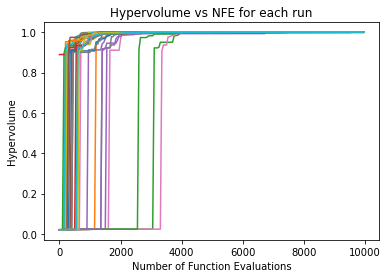

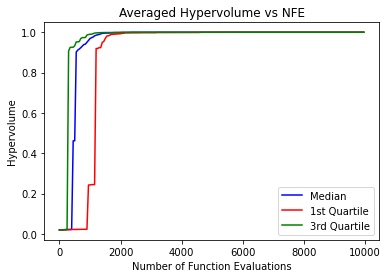

Plotting hypervolume for true objectives case
Plotting


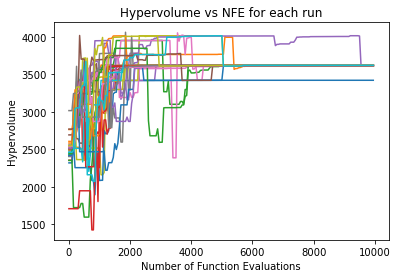

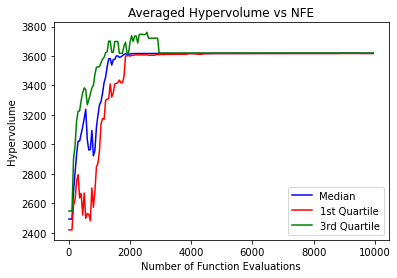

Hypervolume computation for 30 Epsilon MOEA runs using truss model and random initialization
Computing pareto fronts for run 0
Computing pareto fronts for run 1
Computing pareto fronts for run 2
Computing pareto fronts for run 3
Computing pareto fronts for run 4
Computing pareto fronts for run 5
Computing pareto fronts for run 6
Computing pareto fronts for run 7
Computing pareto fronts for run 8
Computing pareto fronts for run 9
Computing pareto fronts for run 10
Computing pareto fronts for run 11
Computing pareto fronts for run 12
Computing pareto fronts for run 13
Computing pareto fronts for run 14
Computing pareto fronts for run 15
Computing pareto fronts for run 16
Computing pareto fronts for run 17
Computing pareto fronts for run 18
Computing pareto fronts for run 19
Computing pareto fronts for run 20
Computing pareto fronts for run 21
Computing pareto fronts for run 22
Computing pareto fronts for run 23
Computing pareto fronts for run 24
Computing pareto fronts for run 25
Computi

ValueError: 
function: assert_minimisation
where: D:\bld\pagmo_1585856951376\work\src\utils\hv_algos\hv_algorithm.cpp, 256
what: Reference point is invalid: another point seems to be outside the reference point boundary, or be equal to it:
 P[0]	= (17.683074, 6.961468)
 R	= (1.100000, 1.100000)



In [7]:
#### Program Operation

# set to: true - to read results for fibre stiffness model run
#         false - to read results for truss model run
model_fib = True

# set algorithm_choie to: eps_moea - if Epsilon MOEA was used
#                         aos_feas_stab_false - if AOS MOEA was used
#                         sc_dnf - if Disjunctive Normal Form was used
#                         sc_ach - if Adaptive Constraint Handling was used

# set to: true - if biased initialization is used
#         false - if random initialization is used
biased_initialization = True

number_runs = 30

# Name for saving plots
# mode: 0 - full
#       1 - true
#       2 - afterjump
def determine_savename(fibre_model, algor, init_biased, mode):
    if fibre_model:
        savename1 = 'fib_'
    else:
        savename1 = 'truss_'
        
    if algor == 'eps_moea':
        savename2 = 'eps_'
    elif algor == 'aos_feas_stab_false':
        savename2 = 'aos_'
    elif algor == 'sc_dnf':
        savename2 = 'dnf_'
    elif algor == 'sc_ach':
        savename2 = 'ach_'
        
    if init_biased:
        savename3 = 'biasedinit_'
    else:
        savename3 = 'randominit_'
        
    if mode == 0:
        savename4 = 'full_'
    elif mode == 1:
        savename4 = 'true_'
    elif mode == 2:
        savename4 = 'afterjump_'
        
    return savename1+savename2+savename3+savename4

# For Epsilon MOEA runs using fibre stiffness model (random initialization)
print('Hypervolume computation for ' + str(number_runs) + ' Epsilon MOEA runs using fibre stiffness model and random initialization')
hv_full_dict_eps_fib_rand, hv_aj_dict_eps_fib_rand, hv_true_dict_eps_fib_rand, hv_stats_full_eps_fib_rand, hv_stats_true_eps_fib_rand, nfe_jump_eps_fib_rand = store_hypervolumes_allruns(model_fib, 'eps_moea', not biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_eps_fib_rand = determine_savename(model_fib, 'eps_moea', not biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_eps_fib_rand, hv_stats_full_eps_fib_rand, number_runs, savename_full_eps_fib_rand)
print('Plotting hypervolume for true objectives case')
savename_true_eps_fib_rand = determine_savename(model_fib, 'eps_moea', not biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_eps_fib_rand, hv_stats_true_eps_fib_rand, number_runs, savename_true_eps_fib_rand)

# For Epsilon MOEA runs using truss stiffness model (random initialization)
print('Hypervolume computation for ' + str(number_runs) + ' Epsilon MOEA runs using truss model and random initialization')
hv_full_dict_eps_truss_rand, hv_aj_dict_eps_truss_rand, hv_true_dict_eps_truss_rand, hv_stats_full_eps_truss_rand, hv_stats_true_eps_truss_rand, nfe_jump_eps_truss_rand = store_hypervolumes_allruns(not model_fib, 'eps_moea', not biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_eps_truss_rand = determine_savename(not model_fib, 'eps_moea', not biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_eps_truss_rand, hv_stats_full_eps_truss_rand, number_runs, savename_full_eps_truss_rand)
print('Plotting hypervolume for true objectives case')
savename_true_eps_truss_rand = determine_savename(not model_fib, 'eps_moea', not biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_eps_truss_rand, hv_stats_true_eps_truss_rand, number_runs, savename_true_eps_truss_rand)

# For Epsilon MOEA runs using fibre stiffness model (biased initialization)
print('Hypervolume computation for ' + str(number_runs) + ' Epsilon MOEA runs using fibre stiffness model and biased initialization')
hv_full_dict_eps_fib_bias, hv_aj_dict_eps_fib_bias, hv_true_dict_eps_fib_bias, hv_stats_full_eps_fib_bias, hv_stats_true_eps_fib_bias, nfe_jump_eps_fib_bias = store_hypervolumes_allruns(model_fib, 'eps_moea', biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_eps_fib_bias = determine_savename(model_fib, 'eps_moea', biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_eps_fib_bias, hv_stats_full_eps_fib_bias, number_runs, savename_full_eps_fib_bias)
print('Plotting hypervolume for true objectives case')
savename_true_eps_fib_bias = determine_savename(model_fib, 'eps_moea', biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_eps_fib_bias, hv_stats_true_eps_fib_bias, number_runs, savename_true_eps_fib_bias)

# For Epsilon MOEA runs using truss stiffness model (biased initialization)
print('Hypervolume computation for ' + str(number_runs) + ' Epsilon MOEA runs using truss model and biased initialization')
hv_full_dict_eps_truss_bias, hv_aj_dict_eps_truss_bias, hv_true_dict_eps_truss_bias, hv_stats_full_eps_truss_bias, hv_stats_true_eps_truss_bias, nfe_jump_eps_truss_bias = store_hypervolumes_allruns(not model_fib, 'eps_moea', biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_eps_truss_bias = determine_savename(not model_fib, 'eps_moea', biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_eps_truss_bias, hv_stats_full_eps_truss_bias, number_runs, savename_full_eps_truss_bias)
print('Plotting hypervolume for true objectives case')
savename_true_eps_truss_bias = determine_savename(not model_fib, 'eps_moea', biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_eps_truss_bias, hv_stats_true_eps_truss_bias, number_runs, savename_true_eps_truss_bias)

# For AOS MOEA runs using fibre stiffness model 
print('Hypervolume computation for ' + str(number_runs) + ' AOS MOEA runs using fibre stiffness model')
hv_full_dict_aos_fib, hv_aj_dict_aos_fib, hv_true_dict_aos_fib, hv_stats_full_aos_fib, hv_stats_true_aos_fib, nfe_jump_aos_fib = store_hypervolumes_allruns(model_fib, 'aos_feas_stab_false', not biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_aos_fib = determine_savename(model_fib, 'aos_feas_stab_false', not biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_aos_fib, hv_stats_full_aos_fib, number_runs, savename_full_aos_fib)
print('Plotting hypervolume for true objectives case')
savename_true_aos_fib = determine_savename(model_fib, 'aos_feas_stab_false', not biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_aos_fib, hv_stats_true_aos_fib, number_runs, savename_true_aos_fib)

# For AOS MOEA runs using truss model 
print('Hypervolume computation for ' + str(number_runs) + ' AOS MOEA runs using truss model')
hv_full_dict_aos_truss, hv_aj_dict_aos_truss, hv_true_dict_aos_truss, hv_stats_full_aos_truss, hv_stats_true_aos_truss, nfe_jump_aos_truss = store_hypervolumes_allruns(not model_fib, 'aos_feas_stab_false', not biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_aos_truss = determine_savename(not model_fib, 'aos_feas_stab_false', not biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_aos_truss, hv_stats_full_aos_truss, number_runs, savename_full_aos_truss)
print('Plotting hypervolume for true objectives case')
savename_true_aos_truss = determine_savename(not model_fib, 'aos_feas_stab_false', not biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_aos_truss, hv_stats_true_aos_truss, number_runs, savename_true_aos_truss)

# For Disjunctive Normal Form runs using fibre stiffness model
print('Hypervolume computation for ' + str(number_runs) + ' Disjunctive Normal Form runs using fibre stiffness model')
hv_full_dict_dnf_fib, hv_aj_dict_dnf_fib, hv_true_dict_dnf_fib, hv_stats_full_dnf_fib, hv_stats_true_dnf_fib, nfe_jump_dnf_fib = store_hypervolumes_allruns(model_fib, 'sc_dnf', not biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_dnf_fib = determine_savename(model_fib, 'sc_dnf', biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_dnf_fib, hv_stats_full_dnf_fib, number_runs, savename_full_dnf_fib)
print('Plotting hypervolume for true objectives case')
savename_true_dnf_fib = determine_savename(model_fib, 'sc_dnf', biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_dnf_fib, hv_stats_true_dnf_fib, number_runs, savename_true_dnf_fib)

# For Disjunctive Normal Form runs using truss model
print('Hypervolume computation for ' + str(number_runs) + ' Disjunctive Normal Form runs using truss model')
hv_full_dict_dnf_truss, hv_aj_dict_dnf_truss, hv_true_dict_dnf_truss, hv_stats_full_dnf_truss, hv_stats_true_dnf_truss, nfe_jump_dnf_truss = store_hypervolumes_allruns(not model_fib, 'sc_dnf', not biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_dnf_truss = determine_savename(not model_fib, 'sc_dnf', biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_dnf_truss, hv_stats_full_dnf_truss, number_runs, savename_full_dnf_truss)
print('Plotting hypervolume for true objectives case')
savename_true_dnf_truss = determine_savename(not model_fib, 'sc_dnf', biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_dnf_truss, hv_stats_true_dnf_truss, number_runs, savename_true_dnf_truss)

# For Adaptive Constraint Handling runs using fibre stiffness model
print('Hypervolume computation for ' + str(number_runs) + ' Adaptive Constraint Handling runs using fibre stiffness model')
hv_full_dict_ach_fib, hv_aj_dict_ach_fib, hv_true_dict_ach_fib, hv_stats_full_ach_fib, hv_stats_true_ach_fib, nfe_jump_ach_fib = store_hypervolumes_allruns(model_fib, 'sc_ach', not biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_ach_fib = determine_savename(model_fib, 'sc_ach', biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_ach_fib, hv_stats_full_ach_fib, number_runs, savename_full_ach_fib)
print('Plotting hypervolume for true objectives case')
savename_true_ach_fib = determine_savename(model_fib, 'sc_ach', biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_ach_fib, hv_stats_true_ach_fib, number_runs, savename_true_ach_fib)

# For Adaptive Constraint Handling runs using truss model
print('Hypervolume computation for ' + str(number_runs) + ' Adaptive Constraint Handling runs using truss model')
hv_full_dict_ach_truss, hv_aj_dict_ach_truss, hv_true_dict_ach_truss, hv_stats_full_ach_truss, hv_stats_true_ach_truss, nfe_jump_ach_truss = store_hypervolumes_allruns(not model_fib, 'sc_ach', not biased_initialization, number_runs)
print('Plotting hypervolume for full penalized objectives case')
savename_full_ach_truss = determine_savename(not model_fib, 'sc_ach', biased_initialization, 0)
plot_hypervolume_allruns(hv_full_dict_ach_truss, hv_stats_full_ach_truss, number_runs, savename_full_ach_truss)
print('Plotting hypervolume for true objectives case')
savename_true_ach_truss = determine_savename(not model_fib, 'sc_ach', biased_initialization, 1)
plot_hypervolume_allruns(hv_true_dict_ach_truss, hv_stats_true_ach_truss, number_runs, savename_true_ach_truss)

In [ ]:
##### BOX PLOTS FOR NFE TO OVERCOME FEASIBILITY BARRIER

fig3 = plt.figure(1)
ax = fig3.add_axes([0,0,1,1])
bp = ax.boxplot([nfe_jump_eps_fib_rand,nfe_jump_eps_truss_rand,nfe_jump_eps_fib_bias,nfe_jump_eps_truss_bias,nfe_jump_aos_fib,nfe_jump_aos_truss,nfe_jump_dnf_fib,nfe_jump_dnf_truss,nfe_jump_ach_fib,nfe_jump_ach_truss])
ax.set_xticklabels(['fib_eps_rand','truss_eps_rand','fib_eps_bias','truss_eps_bias','fib_aos','truss_aos','dnf_fib','dnf_truss','ach_fib','ach_truss'])
plt.ylabel('Number of Function Evaluations')
plt.title('Boxplot for NFE to clear feasibility threshold')
#fig3.savefig('NFE_boxplot.png')